In [246]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from math import ceil
from scipy.linalg import sqrtm
from scipy.sparse.linalg import svds
from scipy.sparse import lil_matrix, csr_matrix, diags, issparse

## Algorithm

In [247]:
class MatrixMemoryTracker:

    def __init__(self):
        self._d = {}
        self.max = 0
        self.total = 0
        self.enable = True
    
    def dump(self):
        print("max = ", self.max, "dict = ", self._d)
        
    def _get_size(self, obj):
        if issparse(obj):
            return obj.nnz * obj.dtype.itemsize
        else:
            return obj.nbytes

    def track(self, matrix, key):
        if self.enable:
            if key in self._d:
                self.total -= self._d[key]    
        
            self.total += self._get_size(matrix)
            self._d[key] = self._get_size(matrix)
        
            if self.total > self.max:
                self.max = self.total
    
    def remove(self, key):
        if self.enable:
            self.total -= self._d[key]
            self._d.pop(key, None)

In [248]:
def gen_columns(M):
    '''
    Yileds columns of matrix M. Prevents from out-of-order access
    to matrix columns. It can be used to simulate data streaming.
    '''
    for i in range(M.shape[1]):
        yield M[:, i]

In [249]:
def sample_entry(M, delta):
    A = lil_matrix(M.shape, dtype=np.float64)
    mmt.track(A, "sample_entry:A")
    
    for i in range(M.shape[1]):
        sample = np.random.choice(2, M.shape[0], p=[1 - delta, delta])
        A[:, i] = (M[:, i] * sample).reshape(-1, 1)
        mmt.track(A, "sample_entry:A")

    mmt.remove("sample_entry:A")
    return A

In [250]:
def SPCA(C, k):
    omega = np.random.randn(C.shape[1], k)
    omega = csr_matrix(omega)
    mmt.track(omega, "sample_entry:omega")
    
    _C = lil_matrix(C.shape)
    mmt.track(_C, "sample_entry:_C")
    
    # Trimming
    for i in range (C.shape[0]):
        if (C.getrow(i).count_nonzero() > 10):
            _C[i, :] = 0
        else:
            _C[i, :] = C[i, :]
    
    _C = _C.tocsr()
    mmt.track(_C, "sample_entry:_C")
    
    diag_matrix = diags(diagonals=((_C.T @ _C).diagonal()), offsets=0, format="csr")
    mmt.track(diag_matrix, "sample_entry:diag_matrix")
    
    F = _C.T @ _C - diag_matrix
    mmt.track(F, "sample_entry:F")
    mmt.remove("sample_entry:diag_matrix")
    mmt.remove("sample_entry:_C")
    F = F.todense()
    mmt.track(F, "sample_entry:F")
    power = int(np.ceil(5 * np.log(C.shape[1])))
        
    F = np.linalg.matrix_power(F, power)
    mmt.track(F, "sample_entry:F")
    F = F @ omega
    mmt.remove("sample_entry:omega")
    mmt.track(F, "sample_entry:F")
    Q, _ = np.linalg.qr(F)
    mmt.remove("sample_entry:F")

    return Q[:, :k]

In [262]:
def SLA(M_cols, m, n, k, delta, l):
    
   #l_samples = list(np.random.choice(n, l, replace=True))
    l_samples = np.arange(l)
    
    A_b1 = lil_matrix((m, l), dtype=np.float32)
    mmt.track(A_b1, "SLA:A_b1")
    A_b2 = lil_matrix((m, l), dtype=np.float32)
    mmt.track(A_b1, "SLA:A_b2")
    
    for j in l_samples:
        M_l = next(M_cols)
        mmt.track(M_l, "SLA:M_l")

        sample = np.random.choice(2, m, p=[1 - delta, delta])
        A_b1[:, j] = (M_l * sample).reshape(-1, 1)
        mmt.track(A_b1, "SLA:A_b1")

        sample = np.random.choice(2, m, p=[1 - delta, delta])
        A_b2[:, j] = (M_l * sample).reshape(-1, 1)
        mmt.track(A_b2, "SLA:A_b2")

        mmt.remove("SLA:M_l")
    
    A_b1 = A_b1.tocsr()
    mmt.track(A_b1, "SLA:A_b1")

    Q = SPCA(A_b1, k)
    mmt.track(Q, "SLA:Q")
    
    for i in range(m):
        if ((A_b2.getrow(i).count_nonzero()) > 2):
            A_b2[i, :] = 0
            
    for i in range(l):
        if ((A_b2.getcol(i).count_nonzero()) > 10 * delta * m):
            A_b2[:, i] = 0

    mmt.track(A_b1, "SLA:A_b2")
    
    A_b2 = A_b2.tocsr()
    mmt.track(A_b1, "SLA:A_b2")

    W = A_b2 @ Q
    mmt.track(W, "SLA:W")
    mmt.remove("SLA:A_b2")
    mmt.remove("SLA:Q")
    V = np.zeros((n, k))
    mmt.track(V, "SLA:V")
    
    V[:l, :] = A_b1.T @ W
    mmt.track(V, "SLA:V")
    I = A_b1 @ V[:l, :]
    mmt.track(I, "SLA:I")
    mmt.remove("SLA:A_b1")
    
    for t in range(l, n):
        sample = np.random.choice(2, m, p=[1 - delta, delta])
        A_t = next(M_cols) * sample
        mmt.track(A_t, "SLA:A_t")
        V[t, :] = A_t.reshape(1, -1) @ W
        mmt.track(V, "SLA:V")
        I += A_t.reshape(-1, 1) @ V[t, :].reshape(1, -1)
        mmt.track(I, "SLA:I")
    mmt.remove("SLA:W")
    mmt.remove("SLA:A_t")
    
    R = sqrtm(V.T @ V)
    mmt.track(R, "SLA:R")
    R = np.linalg.inv(R)
    mmt.track(R, "SLA:R")
    
    U = (1.0 / delta) * (I @ R @ R.T)   
    mmt.track(U, "SLA:U")
    mmt.remove("SLA:R")
    mmt.remove("SLA:I")
    M_k = U @ V.T
    
    #mmt.dump()
    
    return M_k      

## Evaluation

### 1. Background/Foreground separation

In [263]:
def load_sequence_video(path, start, stop):
    
    files = sorted(os.listdir(path))
    frame = Image.open(os.path.join(path, files[0]))
    frame = frame.convert("L")
    frame = np.array(frame)
    
    frame_size = frame.shape
    size = frame.shape[0] * frame.shape[1]

    M = np.zeros((size, stop - start), np.float32)
    
    for i in range(start, stop):
        frame = Image.open(os.path.join(path, files[i])).convert("L")
        frame = np.array(frame) / 255.0
        M[:, i] = frame.reshape(-1)
    
    return M, frame_size


def display_result_video(M, L, S, idx):
    n = M.shape[2]
    
    for i in idx:
        plt.figure(figsize=(16, 6))
        
        plt.subplot(1, 3, 1)
        plt.imshow(M[:,:,i], cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(L[:,:,i], cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(S[:,:,i], cmap='gray')
        plt.axis('off')

videos = [
            "./videos/Bootstrap",
            "./videos/Camouflage",
            "./videos/ForegroundAperture",
            "./videos/LightSwitch",
            "./videos/MovedObject",
            "./videos/TimeOfDay",
            "./videos/WavingTrees"
         ]

start = 0
stop = 3050
M_video, frame_size_video = load_sequence_video(videos[0], start, stop)

In [269]:
delta = 0.1
l = 15

M_video = M_video.astype(np.float64)
m0, n0 = M_video.shape

stats = [None] * 7

for i, s in tqdm(enumerate(range(40, 101, 10))):
    ram_stats = []
    for k in range(1, l + 1):
        n, m = int(n0 * s / 100), int(m0 * s / 100)
        mmt = MatrixMemoryTracker()
        res_video = SLA(gen_columns(M_video[:m, :n]), m, n, k, delta, l)
        ram_stats.append(mmt.max)
    stats[i] = ram_stats.copy()












0it [00:00, ?it/s]










1it [00:38, 38.37s/it]










2it [01:24, 40.78s/it]










3it [02:24, 46.50s/it]










4it [03:38, 54.65s/it]










5it [05:06, 64.80s/it]










6it [06:51, 76.86s/it]










7it [08:52, 90.09s/it]












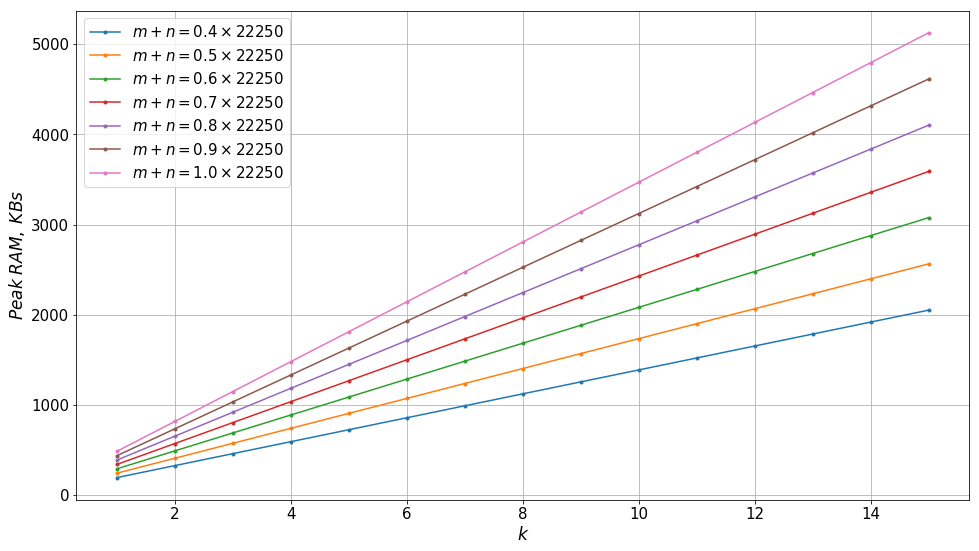

In [271]:
plt.figure(figsize=(16, 9))
cs = np.array(range(40, 101, 10)) / 100

ks = list(range(1, l + 1))
plt.ylabel(r"$Peak\;RAM,\;KBs$", size=17)
plt.xlabel(r"$k$", size=17)
for i, s in enumerate(stats):
    plt.plot(ks, np.array(s) / 1000, '.-', label=r"$m + n = {0} \times {1}$".format(cs[i], n0 + m0))
plt.grid()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig("ram.png")
plt.show()